In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models
import tensorflow.keras.backend as K
import cv2
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

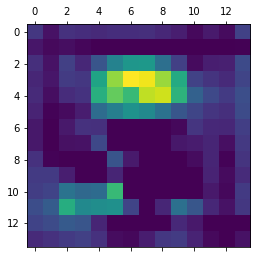

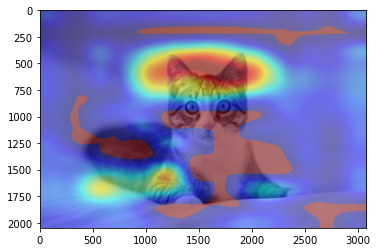

In [4]:
VGG16_model = tf.keras.applications.VGG16(include_top=True)
VGG16_model.summary()
def prepocess(x):
    x = tf.io.read_file(x)
    x = tf.image.decode_jpeg(x, channels=3)
    x = tf.image.resize(x, [224,224])
    print('x_shape1',x.shape)
    x = tf.expand_dims(x, 0) # 扩维
    print('x_shape2',x.shape)
    x = preprocess_input(x)
    return x

img_path='cat.jpg'

img=prepocess(img_path)
print('img.shape',img.shape)

# plt.figure("Image") # 图像窗口名称
# plt.imshow(img)
# plt.axis('on') # 关掉坐标轴为 off
# plt.title('image') # 图像题目
# plt.show()

# Predictions = VGG16_model.predict(img)
# print('Predicted:', decode_predictions(Predictions, top=3)[0])
last_conv_layer = VGG16_model.get_layer('block5_conv3')
heatmap_model =models.Model([VGG16_model.inputs], [last_conv_layer.output, VGG16_model.output])
with tf.GradientTape() as gtape:
    conv_output, Predictions = heatmap_model(img)
    prob = Predictions[:, np.argmax(Predictions[0])] # 最大可能性类别的预测概率
    grads = gtape.gradient(prob, conv_output)  # 类别与卷积层的梯度 (1,14,14,512)
    print('grads',grads)
    pooled_grads = K.mean(grads, axis=(0,1,2)) # 特征层梯度的全局平均代表每个特征层权重
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1) #权重与特征层相乘，512层求和平均
# print('heatmap',heatmap)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
print(heatmap.shape)
# print('heatmap_max',heatmap)

max_heat = np.max(heatmap)
if max_heat == 0:
    max_heat = 1e-10
heatmap /= max_heat
# print('heatmap3',heatmap)
print(heatmap.shape)
plt.matshow(heatmap[0], cmap='viridis')
heatmap = np.uint8(255 * heatmap)
print(heatmap.shape)
# plt.matshow(heatmap)
# plt.imshow(heatmap)
# plt.show()

original_img=cv2.imread('cat.jpg')
heatmap1 = cv2.resize(heatmap[0], (original_img.shape[1], original_img.shape[0]), interpolation=cv2.INTER_CUBIC)
# heatmap1 = np.uint8(255*heatmap)
heatmap1 = np.uint8(255*heatmap1)
heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)
frame_out=cv2.addWeighted(original_img,0.5,heatmap1,0.5,0)
cv2.imwrite('Egyptian_cat.jpg', frame_out)

plt.figure()
plt.imshow(frame_out)
Predictions3=Predictions.numpy()
Predictions3[0][np.argmax(Predictions3[0])]=np.min(Predictions3)
Predictions3[0][np.argmax(Predictions3[0])]=np.min(Predictions3)

In [ ]:
https://blog.csdn.net/Forrest97/article/details/105895591
https://cloud.videojj.com/bbs/topic/35/fpn%E7%9A%84tensorflow%E4%BB%A3%E7%A0%81%E8%AF%A6%E8%A7%A3-%E7%89%B9%E5%BE%81%E6%8F%90%E5%8F%96/2

In [ ]:
https://tensorflow.google.cn/api_docs/python/tf/GradientTape?hl=zh-CN